In [1]:
import numpy as np
from sklearn.decomposition import PCA
import joblib
import librosa
import deeplake
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler 
from imblearn.over_sampling import SMOTE
import matplotlib as mpl
import matplotlib.pyplot as plt

c:\Users\Toazt\anaconda3\lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (4.1.17) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [ ]:
def standardize_mfcc_length(mfcc_list, target_length=100):
    """Standardize MFCC matrices to a fixed length"""
    result = []
    for mfcc in mfcc_list:
        current_length = mfcc.shape[1]
        if current_length > target_length:
            # Truncate if longer than target
            standardized = mfcc[:, :target_length]
        else:
            # Pad with zeros if shorter
            padding = np.zeros((mfcc.shape[0], target_length - current_length))
            standardized = np.hstack([mfcc, padding])
        
        # Flatten the matrix for traditional ML models
        result.append(standardized.flatten())
    
    return np.array(result)

# Total number of features per sample: 1300 (13 mfc, length of 100 each)

In [3]:
TARGET_LABELS = {"stop", "go", "up", "down", "left", "right"}

def extract_filtered_mfcc_features(dataset, n_mfcc=13, sample_rate=16000):
    """
    Extracts MFCC features only for the selected words.
    
    Parameters:
    - dataset: The Deeplake dataset containing audio tensors.
    - n_mfcc: Number of MFCC coefficients to extract.
    - sample_rate: Target sample rate for librosa processing.
    
    Returns:
    - X: NumPy array of MFCC features (num_samples, n_mfcc)
    - y: NumPy array of corresponding labels
    """
    
    X, y = [], []
    
    for i in range(len(dataset)):
        point_label = dataset.labels[i].data()['text'][0]  

        if point_label in TARGET_LABELS:  # Keep only target samples
            
            audio = dataset['audios'][i].numpy().squeeze()  # Extract audio data
            
            # Compute MFCC
            mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
            # mfcc_mean = np.mean(mfcc, axis=1)  # second method: Can take mean of factors for more simplistic feature set
            
            X.append(mfcc)
            y.append(point_label)
            
    return standardize_mfcc_length(X), np.array(y)

In [4]:

# Load dataset
dataset = deeplake.load('hub://activeloop/speech-commands-train')

|

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/speech-commands-train



\

hub://activeloop/speech-commands-train loaded successfully.



In [5]:
# Extract features
X, y = extract_filtered_mfcc_features(dataset)

# Scale/ normalize features 
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Balance dataset out / generate synthetic samples for under-represented classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

c:\Users\Toazt\anaconda3\lib\site-packages\deeplake\core\tensor.py:713: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(
c:\Users\Toazt\anaconda3\lib\site-packages\deeplake\core\tensor.py:713: UserWarning: Indexing by integer in a for loop, like `for i in range(len(ds)): ... ds.tensor[i]` can be quite slow. Use `for i, sample in enumerate(ds)` instead.
  warnings.warn(


In [6]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# RandomizedSearchCV (GridSearchCV can take a long long time when not using average mfcc's )
# Hypertuning Parameters
param_distributions = {
    'C': [0.01, 0.1, 1.0, 10.0],  # Regularization strength
    'solver': ['newton-cg', 'sag', 'saga', 'liblinear'],  
    'penalty': ['l2', None],  # Regularization method
}


search = RandomizedSearchCV(
    LogisticRegression(max_iter=1000, random_state=42, tol=1e-4, class_weight='balanced'),
    param_distributions=param_distributions,
    verbose = 2,  # Show logs as it runs
    n_iter=6,  # Only sample 6 combinations
    cv=3,  # Folds for cross validation
    n_jobs=-1  # Use all CPU cores
)


# Fit the model
print("Training model...")
search.fit(X_train, y_train)

print(f"Best parameters found: {search.best_params_}")





Training model...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\Toazt\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Toazt\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Toazt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1216, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "c:\Users\Toazt\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_

Best parameters found: {'solver': 'saga', 'penalty': 'l2', 'C': 0.01}


In [7]:
# Evaluate model
y_pred = search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized Logistic Regression Accuracy: {accuracy:.4f}")

print("\nTuned Logist RegressionModel Performance:")
print(classification_report(y_test, y_pred))


Optimized Logistic Regression Accuracy: 0.6443

Tuned Logist RegressionModel Performance:
              precision    recall  f1-score   support

        down       0.64      0.62      0.63       476
          go       0.64      0.63      0.63       476
        left       0.61      0.59      0.60       476
       right       0.69      0.68      0.69       476
        stop       0.72      0.73      0.73       476
          up       0.58      0.62      0.59       476

    accuracy                           0.64      2856
   macro avg       0.64      0.64      0.64      2856
weighted avg       0.64      0.64      0.64      2856



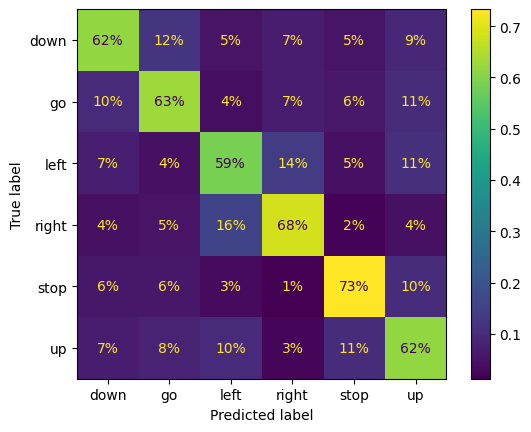

In [8]:
# Show confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.rc('font', size=10)  
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        normalize="true", values_format=".0%")
plt.show()

In [9]:

# Save
joblib.dump(search, 'tuned_logistic_model.pkl')


print("Logistic Regression model saved to tuned_logistic_model.pkl")


Logistic Regression model saved to tuned_logistic_model.pkl


New number of features / dimension size:  139


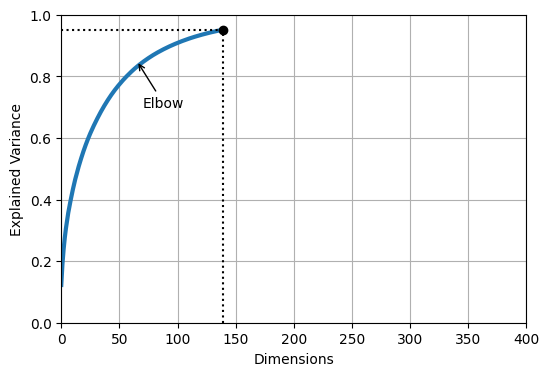

In [35]:
# Reduce features using PCA
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_resampled)

cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

print("New number of features / dimension size: ", d)

plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
plt.show()

In [11]:
# Train model again using reduced features

X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

print("Training model...")
search.fit(X_train, y_train)


# Save
joblib.dump(search, 'PCA_tuned_logistic_model.pkl')


print("Logistic Regression model with reduced features saved to PCA_tuned_logistic_model.pkl")




Training model...
Fitting 3 folds for each of 6 candidates, totalling 18 fits


c:\Users\Toazt\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 18.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Toazt\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Toazt\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1216, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "c:\Users\Toazt\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_

Logistic Regression model with reduced features saved to PCA_tuned_logistic_model.pkl


In [34]:
# Evaluate model
y_pred = search.best_estimator_.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized PCA Logistic Regression Accuracy: {accuracy:.4f}")

print("\nTuned PCA Logistic RegressionModel Performance:")
print(classification_report(y_test, y_pred))


Optimized PCA Logistic Regression Accuracy: 0.6464

Tuned PCA Logistic RegressionModel Performance:
              precision    recall  f1-score   support

        down       0.65      0.61      0.63       476
          go       0.65      0.63      0.64       476
        left       0.61      0.60      0.60       476
       right       0.68      0.68      0.68       476
        stop       0.73      0.73      0.73       476
          up       0.57      0.62      0.60       476

    accuracy                           0.65      2856
   macro avg       0.65      0.65      0.65      2856
weighted avg       0.65      0.65      0.65      2856



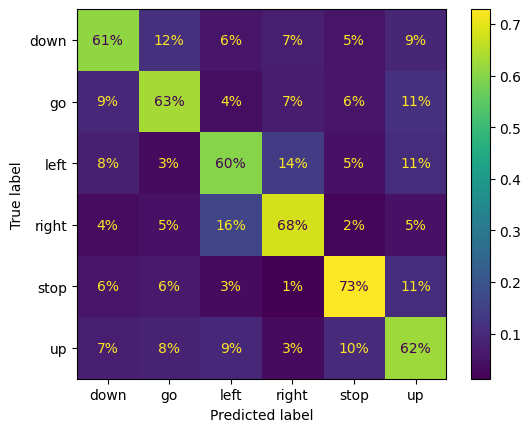

In [13]:
# Show confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.rc('font', size=10)  
ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        normalize="true", values_format=".0%")
plt.show()